In [38]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [39]:
# Load the dataset from CSV file

df = pd.read_csv("data\job_app_confirmation_emails_anonymized.csv")

# data clean

df.rename(columns={
    'Unnamed: 0': 'id',
    'email_body': 'body'
}, inplace=True)

# droppint the redundant index colum if exists after renaming

if 'id' in df.columns:
    df.set_index('id', inplace=True)
    
print("Log: Columns renamed and index set.")
print(f"Log: Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

Log: Columns renamed and index set.
Log: Dataset loaded with 657 rows and 11 columns.


C:\Users\AMAN\AppData\Local\Temp\ipykernel_23476\2926421021.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_senders.values, y=top_senders.index, palette='crest')


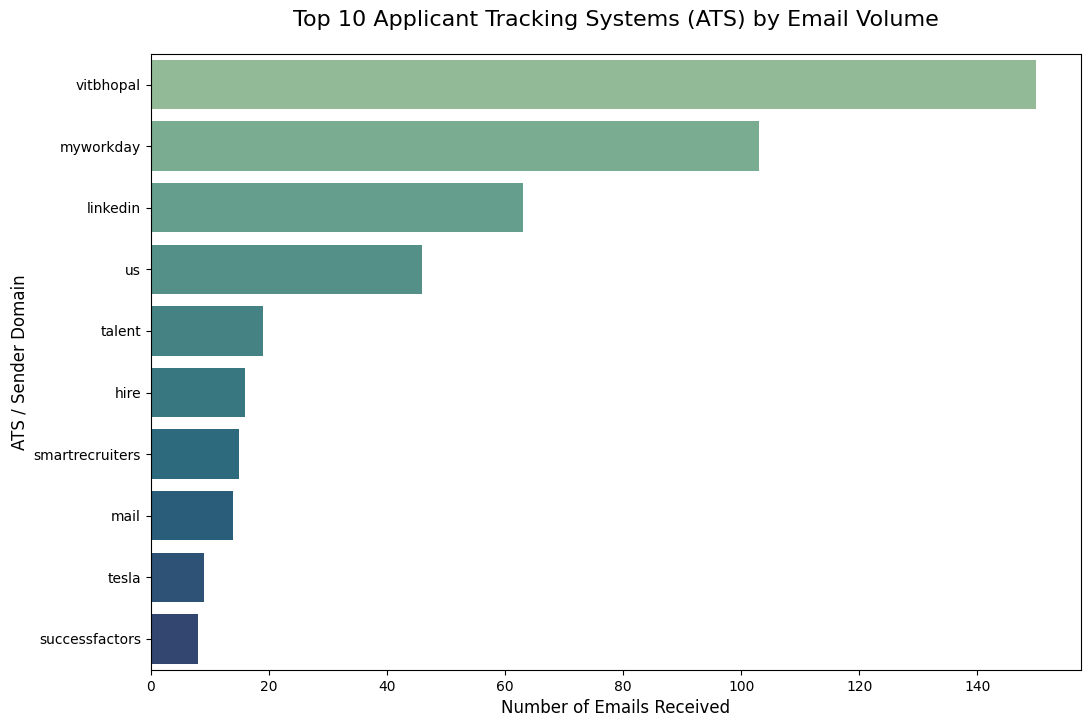

In [51]:
# --- Visualize Top Senders ---
plt.figure(figsize=(12, 8))
# Clean up sender names for better grouping (e.g., group all Workday or Greenhouse emails)
df['sender_domain'] = df['sender'].apply(lambda x: x.split('@')[-1].replace('>', '').split('.')[0] if isinstance(x, str) else 'unknown')
top_senders = df['sender_domain'].value_counts().nlargest(10)

sns.barplot(x=top_senders.values, y=top_senders.index, palette='crest')
plt.title('Top 10 Applicant Tracking Systems (ATS) by Email Volume', fontsize=16, pad=20)
plt.xlabel('Number of Emails Received', fontsize=12)
plt.ylabel('ATS / Sender Domain', fontsize=12)
plt.show()


p2

---

Log: Advanced application status classification complete.
Log: Counts per new status:
 application_status
Applied            362
General            166
Rejection           70
Action Required     53
Offer                6
Name: count, dtype: int64


C:\Users\AMAN\AppData\Local\Temp\ipykernel_23476\3610446271.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')


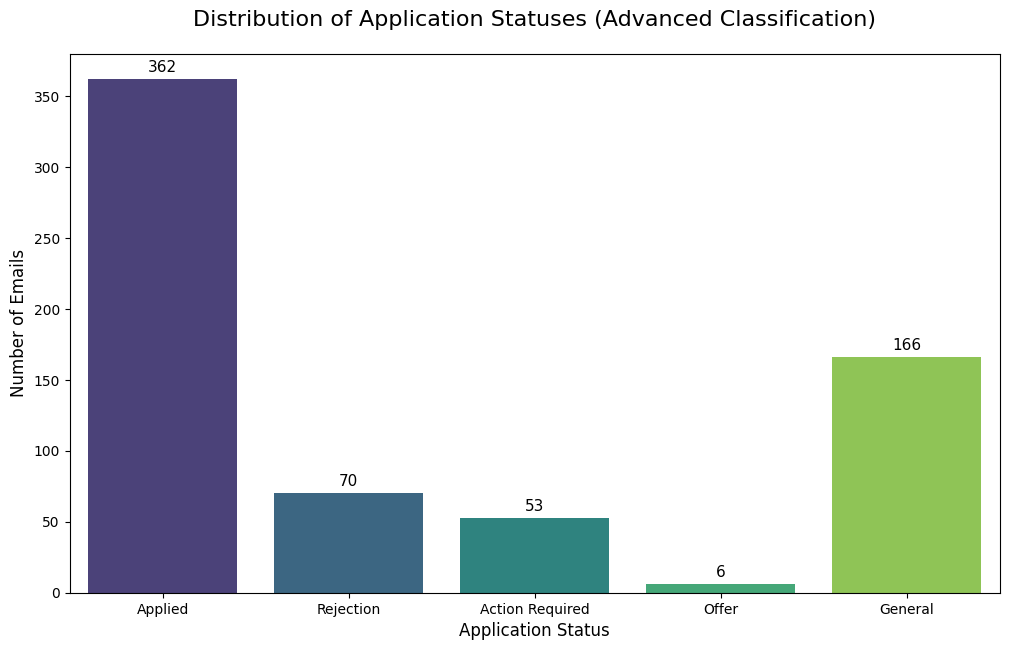

In [52]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

def classify_email_status_advanced(row):
    """
    Performs a "god-level" classification of recruitment emails using a hierarchical,
    multi-layered keyword and regex approach for maximum accuracy.
    
    The logic is tiered to prevent misclassification:
    1.  Check for an Offer.
    2.  Check for a Rejection.
    3.  Check for an Action/Interview request.
    4.  Check for a simple Application Confirmation.
    5.  If none of the above, classify as General.
    """
    text = (str(row['subject']) + ' ' + str(row['body'])).lower()

    # --- Tier 1: Offer of Employment (Highest Priority) ---
    offer_keywords = [
        'offer of employment', 'job offer', 'extend an offer', 'congratulations on the offer',
        'offer letter', 'welcome to the team', 'official offer', 'compensation package',
        'your new role', 'background check' # Often precedes a formal offer
    ]
    if any(keyword in text for keyword in offer_keywords):
        return 'Offer'

    # --- Tier 2: Rejection (High Priority) ---
    # These keywords definitively end the application process for this role.
    rejection_keywords = [
        'not moving forward', 'will not be proceeding', 'not be proceeding', 'decided to move forward with other',
        'pursue other candidates', 'pursue other applicants', 'other applicants whose skills',
        'position has been filled', 'no longer under consideration', 'no longer in the running',
        'not selected for this role', 'application was unsuccessful', 'not a fit at this time',
        'do not have an immediate opening', 'filled the position', 'wish you the best of luck',
        'encourage you to apply for future', 'application has been archived', 'no longer available',
        'after careful consideration', 'regret to inform you', 'difficult decision',
        'weren\'t the right fit', 'will not be advancing', 'thank you for your interest, but',
        'position is no longer open', 'we have selected another candidate'
    ]
    if any(keyword in text for keyword in rejection_keywords):
        return 'Rejection'

    # --- Tier 3: Action Required / Interview (High Engagement Signal) ---
    # These require the applicant to do something.
    action_keywords = [
        'action required', 'next steps', 'next stage', 'next round', 'interview availability',
        'schedule an interview', 'invitation to interview', 'select a time to connect',
        'phone screen', 'phone interview', 'video interview', 'technical interview', 'on-site',
        'coding assessment', 'coding challenge', 'technical test', 'hackerrank', 'codility', 'leetcode',
        'take-home assignment', 'assessment', 'complete your application', 'provide more information',
        'confirm your interest', 'self-schedule', 'next step in the process', 'what to expect',
        'we would like to speak with you', 'request to interview', 'interview schedule', 'online assessment',
        'game-based assessment', 'your availability for an interview'
    ]
    if any(keyword in text for keyword in action_keywords):
        # This logic prevents a simple "application" confirmation from being marked as "Action Required"
        if not ('your application was sent' in text or 'thank you for applying' in text):
             return 'Action Required'

    # --- Tier 4: Application Received / Confirmation (Standard Confirmation) ---
    # These are general "we got it" emails with no immediate action.
    confirmation_keywords = [
        'thank you for applying', 'application received', 'we have received your application',
        'your application has been received', 'application has been submitted', 'we’ve received your application',
        'application is under review', 'successfully submitted', 'confirming your application',
        'your application was sent to', 'thanks for applying', 'submission confirmation',
        'your application for the', 'thank you for your interest'
    ]
    if any(keyword in text for keyword in confirmation_keywords):
        return 'Applied'

    # --- Tier 5: General / Informational (Lowest Priority) ---
    # If none of the above specific categories match, it's likely a general update or newsletter.
    return 'General'

# Apply the new, advanced classification function
df['application_status'] = df.apply(classify_email_status_advanced, axis=1)

print("Log: Advanced application status classification complete.")
status_counts = df['application_status'].value_counts()
print("Log: Counts per new status:\n", status_counts)

# --- Visualize the New, More Accurate Classification Results ---
plt.figure(figsize=(12, 7))
status_order = ['Applied', 'Rejection', 'Action Required', 'Offer', 'General']
# Reindex to ensure consistent order in the plot
status_counts = status_counts.reindex(status_order, fill_value=0)

sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title('Distribution of Application Statuses (Advanced Classification)', fontsize=16, pad=20)
plt.ylabel('Number of Emails', fontsize=12)
plt.xlabel('Application Status', fontsize=12)
for i, count in enumerate(status_counts.values):
    plt.text(i, count + 5, str(count), ha='center', fontsize=11)
plt.show()


---

---p3---

---

Log: Super-accurate extraction with word boundaries is complete.

--- Sample of Correctly Extracted Data ---
               company application_status     extracted_title                                                 skills
id                                                                                                                  
0                Tesco    Action Required  Decision Scientist                                   [decision scientist]
1            Healthify            Applied                None  [sql, tableau, python, product analyst, data analyst]
2               Amazon            Applied                None                                     [business analyst]
3                  IBM            Applied    Business Analyst                                     [business analyst]
4                  IBM          Rejection                None                                     [business analyst]
5             Infineon            General                None           

C:\Users\AMAN\AppData\Local\Temp\ipykernel_23476\492248383.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_skills.values, y=top_skills.index, palette='plasma')


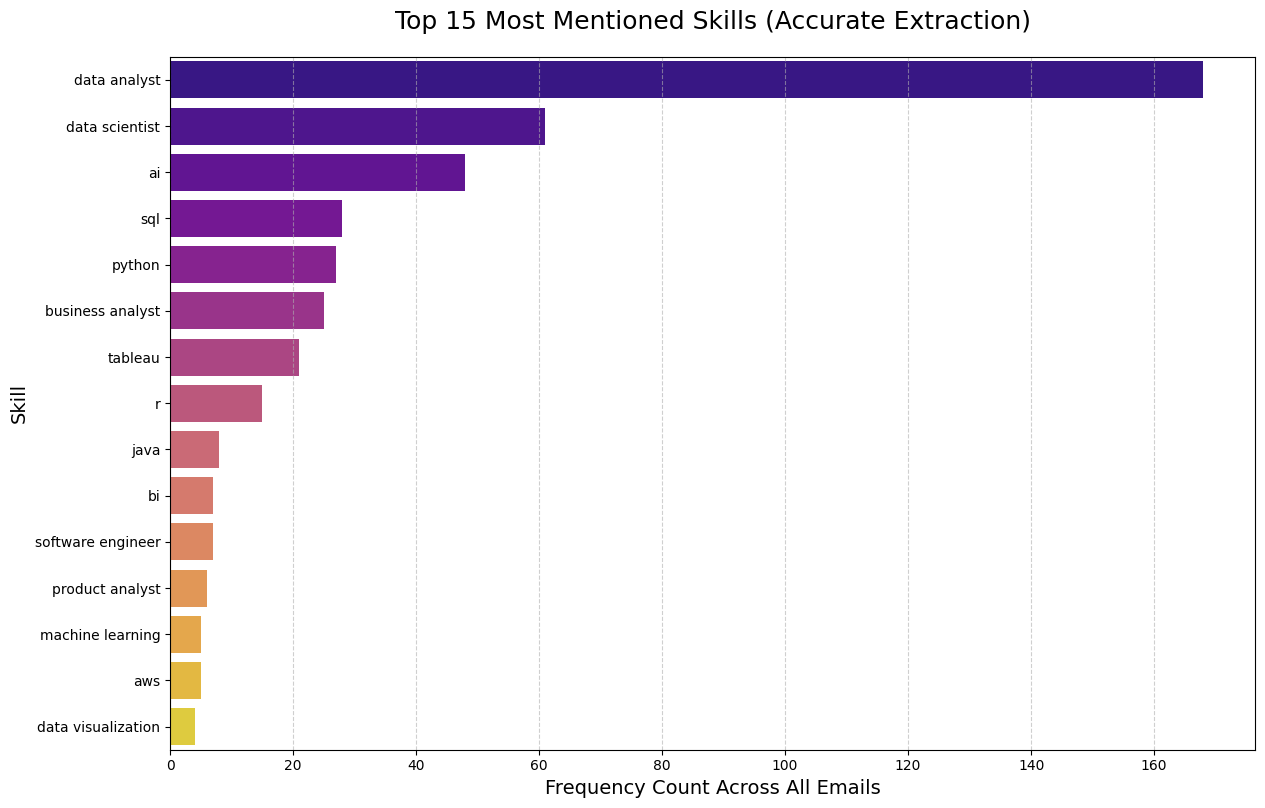

In [55]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# This function will replace the previous, flawed version.
def extract_all_details_accurate(row):
    """
    Performs a "god-level" extraction using a single, efficient regex pattern
    built with word boundaries to ensure logical correctness.
    """
    text = f"{row.get('subject', '')} {row.get('body', '')}"
    text_lower = text.lower()
    
    # --- 1. Job Title Extraction (Stays the same, as it was already robust) ---
    job_title = None
    patterns = [
        r'application for (?:the\s)?([\w\s\-\(\)]+?)\s(?:position|role|at)', r'for the role of\s([\w\s\-\(\)]+?)(?:,|\n|at)',
        r'applying for\s([\w\s\-\(\)]+?)(?:,|\n|at)', r'the\s([\w\s\-\(\)]+?)\sposition at'
    ]
    subject_pattern = r'(Data Analyst|Business Analyst|Product Analyst|Data Scientist|Software Engineer|ML Engineer|Decision Scientist)'
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            job_title = re.sub(r'\s+', ' ', match.group(1).strip()).title()
            if 'At' in job_title: job_title = job_title.split('At')[0].strip()
            break
    if not job_title:
        subject_match = re.search(subject_pattern, row.get('subject', ''), re.IGNORECASE)
        if subject_match: job_title = subject_match.group(1).strip().title()

    # --- 2. Job ID Extraction (Stays the same) ---
    job_id_match = re.search(r'(?:Req ID|Requisition ID|Job ID|Job number|job #)\s?:?\s?([A-Z0-9\-]+)', text, re.IGNORECASE)
    job_id = job_id_match.group(1).strip() if job_id_match else None
    
    # --- 3. SKILL EXTRACTION (THE NEW, ACCURATE LOGIC) ---
    skills_list = [
        'natural language processing', 'machine learning', 'computer vision', 'deep learning',
        'data visualization', 'data warehousing', 'data modeling', 'power bi', 'scikit-learn',
        'software engineer', 'data analyst', 'business analyst', 'product analyst', 'data scientist',
        'decision scientist', 'ml engineer', 'tensorflow', 'pytorch', 'python', 'java', 'sql',
        'c++', 'r', 'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'hadoop', 'spark', 'kafka',
        'linux', 'git', 'etl', 'nlp', 'ai', 'bi', 'devops', 'agile', 'scrum', 'excel', 'tableau'
        # Add any other skills here. The logic will handle them.
    ]
    
    # CRITICAL: Sort skills by length (longest first) to match phrases before sub-phrases.
    # e.g., match 'machine learning' before just 'learning'.
    skills_list.sort(key=len, reverse=True)
    
    # Create a single, powerful regex pattern.
    # We use re.escape to handle special characters like 'c++' correctly.
    # The \b ensures we match whole words only.
    skill_pattern = r'\b(' + '|'.join(re.escape(skill) for skill in skills_list) + r')\b'
    
    # Find all unique matches in the text using the master pattern.
    found_skills = list(set(re.findall(skill_pattern, text_lower, re.IGNORECASE)))
    
    # --- 4. Job Type Extraction (Stays the same) ---
    job_type = 'Full-time'
    if any(term in text_lower for term in ['intern', 'internship', 'co-op']): job_type = 'Internship'
    elif 'contract' in text_lower: job_type = 'Contract'
        
    return pd.Series([job_title, job_id, found_skills, job_type])

# --- Apply the New, Accurate Master Extraction Function ---
df[['extracted_title', 'job_id', 'skills', 'job_type']] = df.apply(extract_all_details_accurate, axis=1)

print("Log: Super-accurate extraction with word boundaries is complete.")

# --- Display a Sample of the Correctly Extracted Data ---
display_columns = ['company', 'application_status', 'extracted_title', 'skills']
print("\n--- Sample of Correctly Extracted Data ---")
print(df[display_columns].head(15).to_string())

# --- Re-run the Skills Visualization with Accurate Data ---
all_skills = df['skills'].explode().dropna()
top_skills = all_skills.value_counts().nlargest(15)

plt.figure(figsize=(14, 9))
sns.barplot(x=top_skills.values, y=top_skills.index, palette='plasma')
plt.title('Top 15 Most Mentioned Skills (Accurate Extraction)', fontsize=18, pad=20)
plt.xlabel('Frequency Count Across All Emails', fontsize=14)
plt.ylabel('Skill', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()



---

p4

---

In [62]:
import pandas as pd
import re
import plotly.express as px
import plotly.graph_objects as go

# ==============================================================================
# STEP 0: LOAD THE DATA
# ==============================================================================
# Always start by loading the original data. Replace with your file path.
file_path = 'data/job_app_confirmation_emails_anonymized.csv'
df = pd.read_csv(file_path)

print("Log: Data loaded successfully from source.")


# ==============================================================================
# STEP 1: DATA CLEANING AND SETUP
# ==============================================================================
# Rename columns needed for the analysis.
df.rename(columns={'Unnamed: 0': 'id', 'email_body': 'body'}, inplace=True)

# Set the 'id' column as the index.
df.set_index('id', inplace=True, drop=True)

# Convert date column, gracefully ignoring malformed dates.
df['date_only'] = pd.to_datetime(df['date_only'], errors='coerce')
df.dropna(subset=['date_only'], inplace=True) # Drop rows where date conversion failed

# **FIX:** Calculate the 'days_since' column needed for the dashboard.
df['days_since'] = (pd.to_datetime('today').normalize() - df['date_only']).dt.days

print("Log: Initial data cleaning and indexing complete.")


# ==============================================================================
# STEP 2: ADVANCED CLASSIFICATION
# ==============================================================================
def classify_email_status_advanced(row):
    """Classifies email into Offer, Rejection, Action Required, Applied, or General."""
    text = (str(row['subject']) + ' ' + str(row['body'])).lower()
    
    # Offer Keywords
    if any(k in text for k in ['offer of employment', 'job offer', 'extend an offer', 'congratulations on the offer', 'offer letter', 'welcome to the team']):
        return 'Offer'
    # Rejection Keywords
    if any(k in text for k in ['not moving forward', 'will not be proceeding', 'pursue other candidates', 'position has been filled', 'no longer under consideration', 'application was unsuccessful', 'not selected', 'regret to inform']):
        return 'Rejection'
    # Action Keywords (avoiding simple confirmations)
    if any(k in text for k in ['action required', 'next steps', 'interview', 'assessment', 'coding challenge', 'schedule a', 'phone screen']):
        if not ('your application was sent' in text or 'thank you for applying' in text):
            return 'Action Required'
    # Confirmation Keywords
    if any(k in text for k in ['thank you for applying', 'application received', 'we have received your application', 'successfully submitted']):
        return 'Applied'
        
    return 'General'

df['application_status'] = df.apply(classify_email_status_advanced, axis=1)
print("Log: Advanced status classification complete.")


# ==============================================================================
# STEP 3: SUPER-ACCURATE EXTRACTION
# ==============================================================================
def extract_all_details_final(row):
    """Extracts Job Title, Job ID, Skills, and Job Type from email text."""
    text = f"{row.get('subject', '')} {row.get('body', '')}"
    text_lower = text.lower()
    
    # Job Title Extraction
    job_title = None
    patterns = [
        r'(?:application|interest) for (?:the\s)?([\w\s\-\(\)]+?)\s(?:position|role|at)',
        r'the role of\s([\w\s\-\(\)]+?)(?:,|\n|at)',
        r'position of\s([\w\s\-\(\)]+?)(?:,|\n|at)'
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            job_title = re.sub(r'\s+', ' ', match.group(1).strip()).title()
            break
    if not job_title and isinstance(row.get('subject'), str):
        job_title_match = re.search(r'([\w\s]+ Analyst|[\w\s]+ Scientist|[\w\s]+ Engineer)', row.get('subject'))
        if job_title_match:
            job_title = job_title_match.group(1).strip().title()

    # Job ID Extraction
    job_id_match = re.search(r'(?:Req ID|Job ID|Job number|job #)\s?:?\s?([A-Z0-9\-]+)', text, re.IGNORECASE)
    job_id = job_id_match.group(1).strip() if job_id_match else None
    
    # Skills Extraction (sorted to match longer skills first, e.g., 'power bi' before 'bi')
    skills_list = ['python', 'sql', 'tableau', 'power bi', 'java', 'c++', 'machine learning', 'deep learning', 'nlp', 'computer vision', 'tensorflow', 'pytorch', 'scikit-learn', 'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'data modeling', 'etl']
    skills_list.sort(key=len, reverse=True)
    skill_pattern = r'\b(' + '|'.join(re.escape(skill) for skill in skills_list) + r')\b'
    found_skills = list(set(re.findall(skill_pattern, text_lower, re.IGNORECASE)))
    
    # Job Type Extraction
    job_type = 'Full-time'
    if any(term in text_lower for term in ['intern', 'internship']):
        job_type = 'Internship'
        
    return pd.Series([job_title, job_id, found_skills, job_type])

df[['extracted_title', 'job_id', 'skills', 'job_type']] = df.apply(extract_all_details_final, axis=1)
print("Log: Final, accurate extraction complete.")

# ==============================================================================
# STEP 4: THE COMMAND CENTER DASHBOARD
# ==============================================================================
# --- Chart 1: Funnel Analysis Over Time ---
df_sorted = df.sort_values('date_only')
df_sorted['applied_cum'] = (df_sorted['application_status'] == 'Applied').cumsum()
df_sorted['rejection_cum'] = (df_sorted['application_status'] == 'Rejection').cumsum()
df_sorted['action_req_cum'] = (df_sorted['application_status'] == 'Action Required').cumsum()

fig_funnel = go.Figure()
fig_funnel.add_trace(go.Scatter(x=df_sorted['date_only'], y=df_sorted['applied_cum'], mode='lines', name='Applications'))
fig_funnel.add_trace(go.Scatter(x=df_sorted['date_only'], y=df_sorted['action_req_cum'], mode='lines', name='Interviews/Actions'))
fig_funnel.add_trace(go.Scatter(x=df_sorted['date_only'], y=df_sorted['rejection_cum'], mode='lines', name='Rejections', line_dash='dash'))
fig_funnel.update_layout(title_text='<b>Job Application Funnel Over Time</b>', hovermode='x unified', legend_title_text='Status')
fig_funnel.show()

# --- Chart 2: Interactive Treemap ---
df_filtered = df[df['application_status'] != 'General'].copy()
df_filtered['extracted_title'] = df_filtered['extracted_title'].fillna('Title Not Found')

# **FIX 1:** Create a new column with the formatted skills string.
# This converts the list of skills into a single string for the tooltip.
df_filtered['skills_str'] = df_filtered['skills'].apply(lambda skills_list: ', '.join(skills_list) if skills_list else 'None')

# **FIX 2:** Use the new 'skills_str' column in hover_data. This is now simple and unambiguous.
fig_treemap = px.treemap(
    df_filtered,
    path=[px.Constant("All Applications"), 'company', 'application_status', 'extracted_title'],
    title='<b>Interactive Treemap: Companies by Application Status</b>',
    hover_data=['skills_str'] # Use the new pre-formatted column
)
fig_treemap.update_traces(textinfo="label+percent parent")
fig_treemap.show()


# --- Table 3: Actionable Dashboard Table ---
actionable_df = df[df['application_status'].isin(['Applied', 'Action Required'])].sort_values('days_since')
print("\n--- Actionable Job Search Dashboard (Oldest First) ---")
print(actionable_df[['company', 'extracted_title', 'application_status', 'date_only', 'days_since']].to_string())

Log: Data loaded successfully from source.
Log: Initial data cleaning and indexing complete.
Log: Advanced status classification complete.
Log: Final, accurate extraction complete.



--- Actionable Job Search Dashboard (Oldest First) ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           company                                                                             e